In [1]:
import json
import networkx as nx
import os
import pandas as pd
import random
import re
import shutil
import subprocess

In [2]:
tests = True

In [3]:
def gen_grid_graph(dim, weight_range):
    G = nx.grid_2d_graph(*dim).to_directed()
    for u, v in list(G.edges):
        if u[0] > v[0] or u[1] > v[1]:
            G.remove_edge(u, v)
    
    G.add_node('s')
    G.add_node('t')
    for x in G.nodes:
        if x != 's' and x != 't':
            if x[1] == 0:
                G.add_edge('s', x)
            if x[1] == dim[1] - 1:
                G.add_edge(x, 't')
    
    relabel_map = {}
    for x in G.nodes:
        if x != 's' and x != 't':
            relabel_map[x] = str(x[0] * dim[1] + x[1])
    G = nx.relabel_nodes(G, relabel_map)
    
    for u, v in G.edges:
        G[u][v]['weight'] = random.randint(*weight_range)
    
    return G

In [4]:
def visualize_graph(G):
    pos = nx.nx_agraph.graphviz_layout(G)
    nx.draw(G, pos, with_labels=True)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

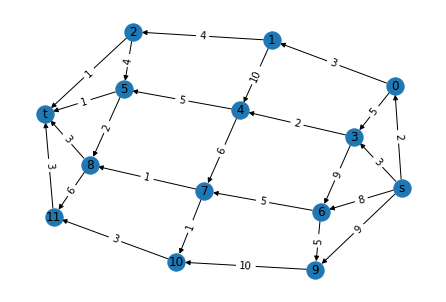

In [5]:
if tests:
    G = gen_grid_graph((4, 3), (1, 10))
    visualize_graph(G)

In [6]:
def gen_int_weights(G, weight_range):
    int_weights = {}
    for u, v in G.edges:
        int_weights[(u, v)] = random.randint(*weight_range)
    return int_weights

In [7]:
def pprint_dict(d):
    print(json.dumps({str(key): d[key] for key in d}, indent=4))

In [8]:
if tests:
    G = gen_grid_graph((5, 5), (1, 10))
    int_weights = gen_int_weights(G, (1, 10))
    pprint_dict(int_weights)

{
    "('0', '5')": 7,
    "('0', '1')": 8,
    "('1', '6')": 9,
    "('1', '2')": 2,
    "('2', '7')": 4,
    "('2', '3')": 9,
    "('3', '8')": 2,
    "('3', '4')": 9,
    "('4', '9')": 3,
    "('4', 't')": 6,
    "('5', '10')": 8,
    "('5', '6')": 10,
    "('6', '11')": 10,
    "('6', '7')": 6,
    "('7', '12')": 5,
    "('7', '8')": 6,
    "('8', '13')": 9,
    "('8', '9')": 10,
    "('9', '14')": 10,
    "('9', 't')": 5,
    "('10', '15')": 6,
    "('10', '11')": 3,
    "('11', '16')": 10,
    "('11', '12')": 9,
    "('12', '17')": 4,
    "('12', '13')": 5,
    "('13', '18')": 8,
    "('13', '14')": 6,
    "('14', '19')": 3,
    "('14', 't')": 10,
    "('15', '20')": 7,
    "('15', '16')": 5,
    "('16', '21')": 5,
    "('16', '17')": 9,
    "('17', '22')": 2,
    "('17', '18')": 2,
    "('18', '23')": 2,
    "('18', '19')": 4,
    "('19', '24')": 8,
    "('19', 't')": 4,
    "('20', '21')": 4,
    "('21', '22')": 10,
    "('22', '23')": 2,
    "('23', '24')": 4,
    "('24', 't')

In [9]:
class ExperimentLogger:
    global_info = ['Experiment Name', '|V|', '|E|', 'Interdiction Budget', 'Number of Refinement Iterations', 'Number of Nodes Per Refinement Partition']
    def __init__(self, solvers, export_path):
        self.info = self.global_info + sum([[f"{x[0]} Objective Value", f"{x[0]} Time"] for x in solvers], [])
        if os.path.exists(export_path):
            self.df = pd.read_csv(export_path)
        else:
            self.df = pd.DataFrame(columns=self.info)
        if os.path.exists('out/subproblem_gaps.csv'):
            self.gap_df = pd.read_csv('out/subproblem_gaps.csv')
        else:
            self.gap_df = pd.DataFrame(columns=["Experiment Name", "Solver", "Gap"])
        self.solvers = solvers
        self.export_path = export_path
        
    def log_experiment(self, experiment_name, G, int_weights, budget, refine_iters, refine_partitions):
        curr_experiment = [experiment_name, len(G.nodes), len(G.edges), budget, refine_iters, refine_partitions]
        
        if os.path.exists(f"experiments/{experiment_name}"):
            shutil.rmtree(f"experiments/{experiment_name}")
        os.mkdir(f"experiments/{experiment_name}")
        nx.write_weighted_edgelist(G, f"experiments/{experiment_name}/graph.edgelist")
        with open(f"experiments/{experiment_name}/interdiction_weight.intvals", 'w+') as f:
            f.write(json.dumps({str(x): int_weights[x] for x in int_weights.keys()}))
        
        for solver in self.solvers:
            print(f"Using {solver[0]} solver")
            
            problem = subprocess.run(["gtime", "-f", "%U", "python3", f"{solver[1]}", experiment_name, str(budget), str(refine_iters), str(refine_partitions)], stderr=subprocess.PIPE, stdout=subprocess.PIPE)
            problem_obj = re.search(r'Objective value: (.*?)\.', str(problem.stdout)).group(1)
            problem_time = float(problem.stderr)
            
            curr_experiment.append(problem_obj)
            curr_experiment.append(problem_time)
            
            if os.path.exists("tmp_gap.txt"):
                with open("tmp_gap.txt", "r") as f:
                    for x in f.readlines():
                        curr = float(x.strip())
                        self.gap_df.loc[len(self.gap_df.index)] = [experiment_name, solver[0], curr]
                os.remove("tmp_gap.txt")
                self.gap_df.to_csv("out/subproblem_gaps.csv")
            
        self.df.loc[len(self.df.index)] = curr_experiment
        self.df.to_csv(self.export_path, index=False)

Using Full Problem solver
Interdiction Weight:
{
    "('0', 't')": 8,
    "('s', '0')": 1
}



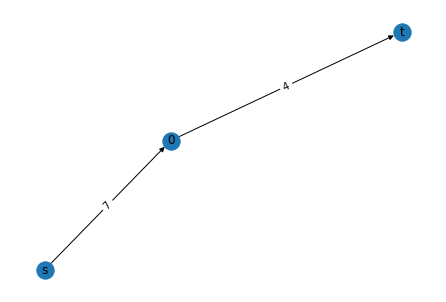

In [10]:
if tests:
    full_problem_logger = ExperimentLogger([("Full Problem", "solvers/solve_full.py")], "out/full_problem.csv")
    
    G = gen_grid_graph((1, 1), (1, 10))
    visualize_graph(G)
    
    int_weights = gen_int_weights(G, (1, 10))
    
    full_problem_logger.log_experiment("graph-1x1", G, int_weights, 1, 0, 0)
    
    print("Interdiction Weight:")
    pprint_dict(int_weights)
    print()

Using Full Problem solver
Interdiction Weight:
{
    "('0', '5')": 4,
    "('0', '1')": 4,
    "('1', '6')": 1,
    "('1', '2')": 6,
    "('2', '7')": 3,
    "('2', '3')": 4,
    "('3', '8')": 8,
    "('3', '4')": 4,
    "('4', '9')": 8,
    "('4', 't')": 9,
    "('5', '10')": 10,
    "('5', '6')": 9,
    "('6', '11')": 6,
    "('6', '7')": 10,
    "('7', '12')": 8,
    "('7', '8')": 6,
    "('8', '13')": 9,
    "('8', '9')": 3,
    "('9', '14')": 3,
    "('9', 't')": 10,
    "('10', '15')": 9,
    "('10', '11')": 10,
    "('11', '16')": 3,
    "('11', '12')": 2,
    "('12', '17')": 3,
    "('12', '13')": 3,
    "('13', '18')": 7,
    "('13', '14')": 4,
    "('14', '19')": 4,
    "('14', 't')": 9,
    "('15', '20')": 6,
    "('15', '16')": 3,
    "('16', '21')": 10,
    "('16', '17')": 5,
    "('17', '22')": 5,
    "('17', '18')": 2,
    "('18', '23')": 8,
    "('18', '19')": 5,
    "('19', '24')": 4,
    "('19', 't')": 2,
    "('20', '21')": 2,
    "('21', '22')": 8,
    "('22', '23')

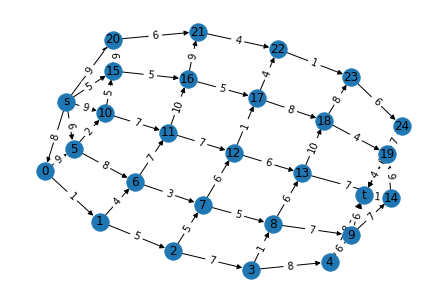

In [11]:
if tests:
    full_problem_logger = ExperimentLogger([("Full Problem", "solvers/solve_full.py")], "out/full_problem.csv")
    
    G = gen_grid_graph((5, 5), (1, 10))
    visualize_graph(G)
    
    int_weights = gen_int_weights(G, (1, 10))
    
    full_problem_logger.log_experiment("graph-5x5", G, int_weights, 1, 0, 0)
    
    print("Interdiction Weight:")
    pprint_dict(int_weights)
    print()